In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
# import os
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats

# Import Ngl with pyn_env active 
#import Ngl

## Need to use metPy conda env
# import metpy.calc as mpc
# from metpy.units import units

import warnings
warnings.filterwarnings('ignore')



## Read in data 

* First focus is on the real surface case, but would be interesting to see if sensitivity holds across surface definition.

In [2]:
start_time = time.time()

saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

realSfc_allCases          = pickle.load( open( saveDir+"realSfc_allCases_withInterp.p", "rb" ) )

HMGclmDS_localReal        = pickle.load( open( saveDir+"HMGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal        = pickle.load( open( saveDir+"HTGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal10      = pickle.load( open( saveDir+"HTGclmDS_localReal10.p", "rb" ) )

HMGclmDS_localRealPatch   = pickle.load( open( saveDir+"HMGclmDS_localRealPatch.p", "rb" ) )
HTGclmDS_localRealPatch   = pickle.load( open( saveDir+"HTGclmDS_localRealPatch.p", "rb" ) )
HTGclmDS_localRealPatch10 = pickle.load( open( saveDir+"HTGclmDS_localRealPatch10.p", "rb" ) )

print('Loaded all the real_sfc pickle files')

artSfc_allCases        = pickle.load( open( saveDir+"artSfc_allCases_withInterp.p", "rb" ) )
artSfcMult_allCases    = pickle.load( open( saveDir+"artSfcMult_allCases_withInterp.p", "rb" ) )

HMGclmDS_localArt        = pickle.load( open( saveDir+"HMGclmDS_localArt.p", "rb" ) )
HTGclmDS_localArt        = pickle.load( open( saveDir+"HTGclmDS_localArt.p", "rb" ) )
HTGclmDS_localArt5       = pickle.load( open( saveDir+"HTGclmDS_localArt5.p", "rb" ) )
HTGclmDS_localArt25      = pickle.load( open( saveDir+"HTGclmDS_localArt25.p", "rb" ) )

HMGclmDS_localArtPatch   = pickle.load( open( saveDir+"HMGclmDS_localArtPatch.p", "rb" ) )
HTGclmDS_localArtPatch   = pickle.load( open( saveDir+"HTGclmDS_localArtPatch.p", "rb" ) )

print('Loaded all the artificial_sfc pickle files')

print('Total elapsed time (sec): ', time.time()-start_time)


Loaded all the real_sfc pickle files
Loaded all the artificial_sfc pickle files
Total elapsed time (sec):  43.41623497009277


In [3]:
## Read in Finley's CSS score data sheet

#filePath = '/Users/mdfowler/Documents/Analysis/CLASP/CSS_15-18_Finley.csv'
filePath = '/Users/mdfowler/Documents/Analysis/CLASP/CSS_LWP_15-18_Finley.csv'

cssDF    = pd.read_csv(filePath, header=0, names=['date','css_neg','css_pos','base_EF'])
# Drop last row (full of Nan)
cssDF    = cssDF[:-1] 

# Turn dates into datetime64
cssDF.date = pd.to_datetime(cssDF.date, format="%m/%d/%y")

# Turn into an xarray dataset (more familiar with that)
cssDS   = cssDF.to_xarray()
cssDS   = cssDS.set_index(index='date')

# Limit to JJA (ignore Sept)
iMonths = np.where( cssDS['index.month']<9 )[0]
cssDS   = cssDS.isel(index=iMonths)


### Add in month-day index to model arrays

In [4]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([HMGclmDS_localReal['time.year'].values,
                                                                HMGclmDS_localReal['time.month'].values, 
                                                                HMGclmDS_localReal['time.day'].values])

realSfc_allCases.coords['year_month_day']        = ('time', month_day_idx)

HMGclmDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localRealPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGclmDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localRealPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGclmDS_localReal10.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localRealPatch10.coords['year_month_day'] = ('time', month_day_idx)


artSfc_allCases.coords['year_month_day']      = ('time', month_day_idx)
artSfcMult_allCases.coords['year_month_day']  = ('time', month_day_idx)

HMGclmDS_localArt.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localArtPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGclmDS_localArt.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localArtPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGclmDS_localArt5.coords['year_month_day']     = ('time', month_day_idx)

HTGclmDS_localArt25.coords['year_month_day']    = ('time', month_day_idx)


In [5]:
# Also throw out any days we don't have in the model dataset
iDrop_start = np.where( (cssDS["index.month"]==6) & (cssDS["index.day"]==1) )[0]
iDrop_end   = np.where( (cssDS["index.month"]==8) & (cssDS["index.day"]>28) )[0]

iDrops      = np.append(iDrop_start, iDrop_end)

allIndices  = np.arange(0, len(cssDS.index))
keepIndices = list(set(allIndices) - set(iDrops))

cssDS = cssDS.isel(index=np.asarray(keepIndices))

In [ ]:
## Add in EF  

realSfc_allCases['EF']  = ( ('case','time','lat,','lon'),
                   (realSfc_allCases['LHFLX']/(realSfc_allCases['LHFLX']+realSfc_allCases['SHFLX'])) )
                              
                              
artSfc_allCases['EF']  = (('case','time','lat,','lon'),
                   (artSfc_allCases['LHFLX']/(artSfc_allCases['LHFLX']+artSfc_allCases['SHFLX'])) )


artSfcMult_allCases['EF']  = (('case','time','lat,','lon'),
                   (artSfcMult_allCases['LHFLX']/(artSfcMult_allCases['LHFLX']+artSfcMult_allCases['SHFLX'])) )


realSfc_allCases['EF'].attrs['units']   = '-'
artSfc_allCases['EF'].attrs['units'] = '-'
artSfcMult_allCases['EF'].attrs['units'] = '-'

realSfc_allCases['EF'].attrs['long_name']   = 'Evaporative Fraction'
artSfc_allCases['EF'].attrs['long_name'] = 'Evaporative Fraction'
artSfcMult_allCases.attrs['long_name'] = 'Evaporative Fraction'


## Do some parsing of CSS data - what *are* the really sensitive days?

In [7]:
def returnNotMatches(a, b):
    a = set(a)
    b = set(b)
    return [list(b - a), list(a - b)]


In [6]:
highPct = 95
lowPct  = 5

istrong_PosDay = np.where(cssDS.css_pos.values >= np.nanpercentile(cssDS.css_pos.values, highPct))[0]
istrong_NegDay = np.where(cssDS.css_neg.values <= np.nanpercentile(cssDS.css_neg.values, lowPct))[0]

# Don't allow days to fall into both categories 
# neg,pos = returnNotMatches(istrong_PosDay, istrong_NegDay)
# dates_positive = cssDS.index[pos]
# dates_negative = cssDS.index[neg]

# Allow days to fall into both categories 
dates_positive = cssDS.index[istrong_PosDay]
dates_negative = cssDS.index[istrong_NegDay]

print('Number of days with strong positive CSS: ', len(dates_positive))
print('Number of days with strong negative CSS: ', len(dates_negative))


Number of days with strong positive CSS:  18
Number of days with strong negative CSS:  18


In [7]:
## Get array of dates that correspond to the rest of days... 

allIndices  = np.arange(0, len(cssDS.index))
iRestDays   = list(set(allIndices) - set(istrong_PosDay) - set(istrong_NegDay))

dates_rest = cssDS.index[iRestDays]



High pct cutoff:  0.0729827035


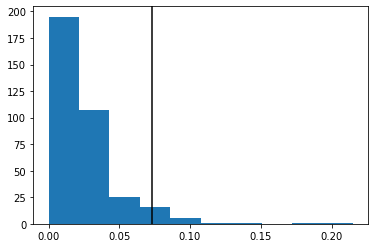

In [8]:
plt.hist(cssDS.css_pos.values)
plt.axvline(np.nanpercentile(cssDS.css_pos.values, highPct), color='k')
print('High pct cutoff: ' , np.nanpercentile(cssDS.css_pos.values, highPct))

In [9]:
cssDS.isel(index=istrong_PosDay)['css_pos']

<xarray.DataArray 'css_pos' (index: 18)>
array([0.11180669, 0.07332984, 0.18374051, 0.07688293, 0.07520625,
       0.07594008, 0.12928761, 0.0780838 , 0.09185925, 0.10406841,
       0.07395569, 0.08390409, 0.08049339, 0.10560724, 0.10020688,
       0.09672024, 0.08478949, 0.21508914])
Coordinates:
  * index    (index) datetime64[ns] 2015-07-06 2015-08-21 ... 2018-08-20

Negative pct cutoff:  -0.0632643096


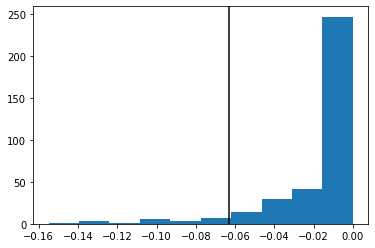

In [10]:
plt.hist(cssDS.css_neg.values)
plt.axvline(np.nanpercentile(cssDS.css_neg.values, lowPct), color='k')
print('Negative pct cutoff: ' , np.nanpercentile(cssDS.css_neg.values, lowPct))

In [11]:
cssDS.isel(index=istrong_NegDay)['css_neg']

<xarray.DataArray 'css_neg' (index: 18)>
array([-0.13851567, -0.09510139, -0.10370981, -0.06631986, -0.08773198,
       -0.1264945 , -0.08708385, -0.11404852, -0.10684953, -0.08037717,
       -0.12474653, -0.15501185, -0.06663002, -0.10321392, -0.09365221,
       -0.06342904, -0.0640769 , -0.09709029])
Coordinates:
  * index    (index) datetime64[ns] 2015-07-06 2015-07-17 ... 2018-08-20

In [12]:
print('Days qualifying with strong postive CSS: \n',dates_positive.values)

Days qualifying with strong postive CSS: 
 ['2015-07-06T00:00:00.000000000' '2015-08-21T00:00:00.000000000'
 '2015-08-23T00:00:00.000000000' '2015-08-26T00:00:00.000000000'
 '2016-06-14T00:00:00.000000000' '2016-07-19T00:00:00.000000000'
 '2016-07-20T00:00:00.000000000' '2016-07-26T00:00:00.000000000'
 '2016-08-04T00:00:00.000000000' '2017-06-14T00:00:00.000000000'
 '2017-07-30T00:00:00.000000000' '2017-08-09T00:00:00.000000000'
 '2017-08-12T00:00:00.000000000' '2017-08-25T00:00:00.000000000'
 '2018-06-08T00:00:00.000000000' '2018-06-27T00:00:00.000000000'
 '2018-08-14T00:00:00.000000000' '2018-08-20T00:00:00.000000000']


In [13]:
print('Days qualifying with strong negative CSS: \n',dates_negative.values)

Days qualifying with strong negative CSS: 
 ['2015-07-06T00:00:00.000000000' '2015-07-17T00:00:00.000000000'
 '2015-07-23T00:00:00.000000000' '2015-07-24T00:00:00.000000000'
 '2015-08-24T00:00:00.000000000' '2015-08-25T00:00:00.000000000'
 '2016-07-08T00:00:00.000000000' '2016-07-20T00:00:00.000000000'
 '2017-07-29T00:00:00.000000000' '2017-07-30T00:00:00.000000000'
 '2017-08-05T00:00:00.000000000' '2017-08-09T00:00:00.000000000'
 '2017-08-16T00:00:00.000000000' '2017-08-25T00:00:00.000000000'
 '2018-06-07T00:00:00.000000000' '2018-06-08T00:00:00.000000000'
 '2018-06-23T00:00:00.000000000' '2018-08-20T00:00:00.000000000']


## Now get those same days in the larger arrays with model output

In [14]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnCSS(fullDS, matchDatesDS):
    iTimes = []
    
    for iTime in range(len(matchDatesDS.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==matchDatesDS['index.year'].values[iTime]) &
                              (fullDS['time.month']==matchDatesDS['index.month'].values[iTime]) & 
                              (fullDS['time.day']  ==matchDatesDS['index.day'].values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)



In [15]:
## Realistic surface 
realSfc_allCases_posCSS     = getTimes_basedOnCSS(realSfc_allCases, dates_positive)
realSfc_allCases_negCSS     = getTimes_basedOnCSS(realSfc_allCases, dates_negative)
realSfc_allCases_restOfDays = getTimes_basedOnCSS(realSfc_allCases, dates_rest)

artSfc_allCases_posCSS     = getTimes_basedOnCSS(artSfc_allCases, dates_positive)
artSfc_allCases_negCSS     = getTimes_basedOnCSS(artSfc_allCases, dates_negative)
artSfc_allCases_restOfDays = getTimes_basedOnCSS(artSfc_allCases, dates_rest)

artSfcMult_allCases_posCSS     = getTimes_basedOnCSS(artSfcMult_allCases, dates_positive)
artSfcMult_allCases_negCSS     = getTimes_basedOnCSS(artSfcMult_allCases, dates_negative)
artSfcMult_allCases_restOfDays = getTimes_basedOnCSS(artSfcMult_allCases, dates_rest)



**Compute hourly means and std**

In [16]:
hourlyMean_posCSS_realSfc    = realSfc_allCases_posCSS.groupby("time.hour").mean(dim="time")
hourlyMean_posCSS_artSfc     = artSfc_allCases_posCSS.groupby("time.hour").mean(dim="time")
hourlyMean_posCSS_artSfcMult = artSfcMult_allCases_posCSS.groupby("time.hour").mean(dim="time")

hourlyMean_negCSS_realSfc    = realSfc_allCases_negCSS.groupby("time.hour").mean(dim="time")
hourlyMean_negCSS_artSfc     = artSfc_allCases_negCSS.groupby("time.hour").mean(dim="time")
hourlyMean_negCSS_artSfcMult = artSfcMult_allCases_negCSS.groupby("time.hour").mean(dim="time")

hourlyMean_restOfDays_realSfc    = realSfc_allCases_restOfDays.groupby("time.hour").mean(dim="time")
hourlyMean_restOfDays_artSfc     = artSfc_allCases_restOfDays.groupby("time.hour").mean(dim="time")
hourlyMean_restOfDays_artSfcMult = artSfcMult_allCases_restOfDays.groupby("time.hour").mean(dim="time")
print('Computed hourly means for all surfaces + cases')


hourlyStd_posCSS_realSfc    = realSfc_allCases_posCSS.groupby("time.hour").std(dim="time")
hourlyStd_posCSS_artSfc     = artSfc_allCases_posCSS.groupby("time.hour").std(dim="time")
hourlyStd_posCSS_artSfcMult = artSfcMult_allCases_posCSS.groupby("time.hour").std(dim="time")

hourlyStd_negCSS_realSfc    = realSfc_allCases_negCSS.groupby("time.hour").std(dim="time")
hourlyStd_negCSS_artSfc     = artSfc_allCases_negCSS.groupby("time.hour").std(dim="time")
hourlyStd_negCSS_artSfcMult = artSfcMult_allCases_negCSS.groupby("time.hour").std(dim="time")

hourlyStd_restOfDays_realSfc    = realSfc_allCases_restOfDays.groupby("time.hour").std(dim="time")
hourlyStd_restOfDays_artSfc     = artSfc_allCases_restOfDays.groupby("time.hour").std(dim="time")
hourlyStd_restOfDays_artSfcMult = artSfcMult_allCases_restOfDays.groupby("time.hour").std(dim="time")

print('Computed hourly std for all surfaces + cases')




Computed hourly means for all surfaces + cases
Computed hourly std for all surfaces + cases


In [17]:
# Get number of obs going into those hourly means (for error bars)
nTimes_posCSS   = np.full([24], np.nan)
nTimes_negCSS   = np.full([24], np.nan)
nTimes_rest     = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_posCSS[iHr]  = len(np.where(realSfc_allCases_posCSS["time.hour"]==iHr)[0])
    nTimes_negCSS[iHr]  = len(np.where(realSfc_allCases_negCSS["time.hour"]==iHr)[0])
    nTimes_rest[iHr]    = len(np.where(realSfc_allCases_restOfDays["time.hour"]==iHr)[0])

hourlyMean_posCSS_realSfc['SampleCount']       = (('hour'), nTimes_posCSS)
hourlyMean_posCSS_artSfc['SampleCount']        = (('hour'), nTimes_posCSS)
hourlyMean_posCSS_artSfcMult['SampleCount']    = (('hour'), nTimes_posCSS)

hourlyMean_negCSS_realSfc['SampleCount']       = (('hour'), nTimes_negCSS)
hourlyMean_negCSS_artSfc['SampleCount']        = (('hour'), nTimes_negCSS)
hourlyMean_negCSS_artSfcMult['SampleCount']    = (('hour'), nTimes_negCSS)

hourlyMean_restOfDays_realSfc['SampleCount']       = (('hour'), nTimes_rest)
hourlyMean_restOfDays_artSfc['SampleCount']        = (('hour'), nTimes_rest)
hourlyMean_restOfDays_artSfcMult['SampleCount']    = (('hour'), nTimes_rest)


## Make some plots!

In [19]:
def diurnalCycle_sfcVars(listVars, sfcType, ymin, ymax):
    # Number of variables to plot
    nVars = len(listVars)
    
    ## Choose with a string which surface cases are of interest to plot 
    if sfcType=='artificial':
        caseNames = np.asarray(['HMG','HTG','HTG*0.5','HTG*0.25'])
        colorList = np.asarray(['red','blue','dodgerblue','skyblue'])
        
        ds1_mean = hourlyMean_posCSS_artSfc
        ds2_mean = hourlyMean_negCSS_artSfc
        ds3_mean = hourlyMean_restOfDays_artSfc
        
        ds1_std = hourlyStd_posCSS_artSfc
        ds2_std = hourlyStd_negCSS_artSfc
        ds3_std = hourlyStd_restOfDays_artSfc
        
    elif sfcType=='real':
        caseNames = np.asarray(['HMG','HTG','HTG*10'])
        colorList = np.asarray(['orange','violet','purple'])
        
        ds1_mean = hourlyMean_posCSS_realSfc
        ds2_mean = hourlyMean_negCSS_realSfc
        ds3_mean = hourlyMean_restOfDays_realSfc
        
        ds1_std = hourlyStd_posCSS_realSfc
        ds2_std = hourlyStd_negCSS_realSfc
        ds3_std = hourlyStd_restOfDays_realSfc
        
    else:
        print('Please define surface type as either artificial or real')
    
    
    ## Set up plots 
    fig,axs = plt.subplots(nVars,3, figsize=(15,nVars*3))
    axs     = axs.ravel()
    fig.subplots_adjust(hspace = 0.5)
    
    iPlot=0    
    for iVar in range(nVars):
        
        ## Check if variable is 3D and select appropriate data: 
        if len(np.shape(hourlyMean_posCSS_artSfc[listVars[iVar]].values))==5:   #Dims: [hour, case, level, lat, lon]
            HMGvar1 = ds1_mean[listVars[iVar]].values[:,0,-1,0,0]
            HTGvar1 = ds1_mean[listVars[iVar]].values[:,1,-1,0,0]
            
            HMGvar2 = ds2_mean[listVars[iVar]].values[:,0,-1,0,0]
            HTGvar2 = ds2_mean[listVars[iVar]].values[:,1,-1,0,0]
            
            HMGvar3 = ds3_mean[listVars[iVar]].values[:,0,-1,0,0]
            HTGvar3 = ds3_mean[listVars[iVar]].values[:,1,-1,0,0]
            
            # Select std for variable too 
            HMGvarStd1 = ds1_std[listVars[iVar]].values[:,0,-1,0,0]
            HTGvarStd1 = ds1_std[listVars[iVar]].values[:,1,-1,0,0]
            
            HMGvarStd2 = ds2_std[listVars[iVar]].values[:,0,-1,0,0]
            HTGvarStd2 = ds2_std[listVars[iVar]].values[:,1,-1,0,0]
            
            HMGvarStd3 = ds3_std[listVars[iVar]].values[:,0,-1,0,0]
            HTGvarStd3 = ds3_std[listVars[iVar]].values[:,1,-1,0,0]
            
            if sfcType=='artificial':
                HTG5_1  = hourlyMean_posCSS_artSfcMult[listVars[iVar]].values[:,0,-1,0,0]
                HTG25_1 = hourlyMean_posCSS_artSfcMult[listVars[iVar]].values[:,1,-1,0,0]
             
                HTG5_2  = hourlyMean_negCSS_artSfcMult[listVars[iVar]].values[:,0,-1,0,0]
                HTG25_2 = hourlyMean_negCSS_artSfcMult[listVars[iVar]].values[:,1,-1,0,0]
                
                HTG5_3  = hourlyMean_restOfDays_artSfcMult[listVars[iVar]].values[:,0,-1,0,0]
                HTG25_3 = hourlyMean_restOfDays_artSfcMult[listVars[iVar]].values[:,1,-1,0,0]
                
                #Get std as well 
                HTG5std_1  = hourlyStd_posCSS_artSfcMult[listVars[iVar]].values[:,0,-1,0,0]
                HTG25std_1 = hourlyStd_posCSS_artSfcMult[listVars[iVar]].values[:,1,-1,0,0]
             
                HTG5std_2  = hourlyStd_negCSS_artSfcMult[listVars[iVar]].values[:,0,-1,0,0]
                HTG25std_2 = hourlyStd_negCSS_artSfcMult[listVars[iVar]].values[:,1,-1,0,0]
                
                HTG5std_3  = hourlyStd_restOfDays_artSfcMult[listVars[iVar]].values[:,0,-1,0,0]
                HTG25std_3 = hourlyStd_restOfDays_artSfcMult[listVars[iVar]].values[:,1,-1,0,0]
                
            elif sfcType=='real':
                HTG10_1 = ds1_mean[listVars[iVar]].values[:,2,-1,0,0]
                HTG10_2 = ds2_mean[listVars[iVar]].values[:,2,-1,0,0]
                HTG10_3 = ds3_mean[listVars[iVar]].values[:,2,-1,0,0]
                
                HTG10std_1 = ds1_std[listVars[iVar]].values[:,2,-1,0,0]
                HTG10std_2 = ds2_std[listVars[iVar]].values[:,2,-1,0,0]
                HTG10std_3 = ds3_std[listVars[iVar]].values[:,2,-1,0,0]
                
        ## 2D data         
        else:                                                     #Dims: [hour, case, lat, lon]
            HMGvar1 = ds1_mean[listVars[iVar]].values[:,0,0,0]
            HTGvar1 = ds1_mean[listVars[iVar]].values[:,1,0,0]
            
            HMGvar2 = ds2_mean[listVars[iVar]].values[:,0,0,0]
            HTGvar2 = ds2_mean[listVars[iVar]].values[:,1,0,0]
            
            HMGvar3 = ds3_mean[listVars[iVar]].values[:,0,0,0]
            HTGvar3 = ds3_mean[listVars[iVar]].values[:,1,0,0]
            
            # Select std for variable too 
            HMGvarStd1 = ds1_std[listVars[iVar]].values[:,0,0,0]
            HTGvarStd1 = ds1_std[listVars[iVar]].values[:,1,0,0]
            
            HMGvarStd2 = ds2_std[listVars[iVar]].values[:,0,0,0]
            HTGvarStd2 = ds2_std[listVars[iVar]].values[:,1,0,0]
            
            HMGvarStd3 = ds3_std[listVars[iVar]].values[:,0,0,0]
            HTGvarStd3 = ds3_std[listVars[iVar]].values[:,1,0,0]
            
            if sfcType=='artificial':
                HTG5_1  = hourlyMean_posCSS_artSfcMult[listVars[iVar]].values[:,0,0,0]
                HTG25_1 = hourlyMean_posCSS_artSfcMult[listVars[iVar]].values[:,1,0,0]
             
                HTG5_2  = hourlyMean_negCSS_artSfcMult[listVars[iVar]].values[:,0,0,0]
                HTG25_2 = hourlyMean_negCSS_artSfcMult[listVars[iVar]].values[:,1,0,0]
                
                HTG5_3  = hourlyMean_restOfDays_artSfcMult[listVars[iVar]].values[:,0,0,0]
                HTG25_3 = hourlyMean_restOfDays_artSfcMult[listVars[iVar]].values[:,1,0,0]
                
                #Get std as well 
                HTG5std_1  = hourlyStd_posCSS_artSfcMult[listVars[iVar]].values[:,0,0,0]
                HTG25std_1 = hourlyStd_posCSS_artSfcMult[listVars[iVar]].values[:,1,0,0]
             
                HTG5std_2  = hourlyStd_negCSS_artSfcMult[listVars[iVar]].values[:,0,0,0]
                HTG25std_2 = hourlyStd_negCSS_artSfcMult[listVars[iVar]].values[:,1,0,0]
                
                HTG5std_3  = hourlyStd_restOfDays_artSfcMult[listVars[iVar]].values[:,0,0,0]
                HTG25std_3 = hourlyStd_restOfDays_artSfcMult[listVars[iVar]].values[:,1,0,0]
                
            elif sfcType=='real':
                HTG10_1 = ds1_mean[listVars[iVar]].values[:,2,0,0]
                HTG10_2 = ds2_mean[listVars[iVar]].values[:,2,0,0]
                HTG10_3 = ds3_mean[listVars[iVar]].values[:,2,0,0]
                
                HTG10std_1 = ds1_std[listVars[iVar]].values[:,2,0,0]
                HTG10std_2 = ds2_std[listVars[iVar]].values[:,2,0,0]
                HTG10std_3 = ds3_std[listVars[iVar]].values[:,2,0,0]
            
            
            
        ## Now see about plotting that (dry days on left, wet days on right)
        
        # First plot just  the HTG and HMG cases for dry and then wet days - these are simple and don't depend sfc
        axs[0+iPlot].errorbar(ds1_mean.hour.values, HMGvar1, 
                          yerr =2*HMGvarStd1/np.sqrt(ds1_mean['SampleCount'].values),
                          fmt='-',color=colorList[0], capsize=3, label=caseNames[0])
        axs[0+iPlot].errorbar(ds1_mean.hour.values, HTGvar1, 
                          yerr =2*HTGvarStd1/np.sqrt(ds1_mean['SampleCount'].values),
                          fmt='-',color=colorList[1], capsize=3, label=caseNames[1])
        
        axs[1+iPlot].errorbar(ds2_mean.hour.values, HMGvar2, 
                          yerr =2*HMGvarStd2/np.sqrt(ds2_mean['SampleCount'].values),
                          fmt='-',color=colorList[0], capsize=3, label=caseNames[0])
        axs[1+iPlot].errorbar(ds2_mean.hour.values, HTGvar2, 
                          yerr =2*HTGvarStd2/np.sqrt(ds2_mean['SampleCount'].values),
                          fmt='-',color=colorList[1], capsize=3, label=caseNames[1])
        
        axs[2+iPlot].errorbar(ds3_mean.hour.values, HMGvar3, 
                          yerr =2*HMGvarStd3/np.sqrt(ds3_mean['SampleCount'].values),
                          fmt='-',color=colorList[0], capsize=3, label=caseNames[0])
        axs[2+iPlot].errorbar(ds3_mean.hour.values, HTGvar3, 
                          yerr =2*HTGvarStd3/np.sqrt(ds3_mean['SampleCount'].values),
                          fmt='-',color=colorList[1], capsize=3, label=caseNames[1])
            
        # Now plot any extra multiplier cases 
        if sfcType=='artificial':
            axs[0+iPlot].errorbar(ds1_mean.hour.values, HTG5_1, 
                          yerr =2*HTG5std_1/np.sqrt(hourlyMean_posCSS_artSfcMult['SampleCount'].values),
                          fmt='-',color=colorList[2], capsize=3, label=caseNames[2])
            axs[0+iPlot].errorbar(ds1_mean.hour.values, HTG25_1, 
                          yerr =2*HTG25std_1/np.sqrt(hourlyMean_posCSS_artSfcMult['SampleCount'].values),
                          fmt='-',color=colorList[3], capsize=3, label=caseNames[3])
            
            axs[1+iPlot].errorbar(ds2_mean.hour.values, HTG5_2, 
                          yerr =2*HTG5std_2/np.sqrt(hourlyMean_negCSS_artSfcMult['SampleCount'].values),
                          fmt='-',color=colorList[2], capsize=3, label=caseNames[2])
            axs[1+iPlot].errorbar(ds2_mean.hour.values, HTG25_2, 
                          yerr =2*HTG25std_2/np.sqrt(hourlyMean_negCSS_artSfcMult['SampleCount'].values),
                          fmt='-',color=colorList[3], capsize=3, label=caseNames[3])
            
            axs[2+iPlot].errorbar(ds3_mean.hour.values, HTG5_3, 
                          yerr =2*HTG5std_3/np.sqrt(hourlyMean_restOfDays_artSfcMult['SampleCount'].values),
                          fmt='-',color=colorList[2], capsize=3, label=caseNames[2])
            axs[2+iPlot].errorbar(ds3_mean.hour.values, HTG25_3, 
                          yerr =2*HTG25std_3/np.sqrt(hourlyMean_restOfDays_artSfcMult['SampleCount'].values),
                          fmt='-',color=colorList[3], capsize=3, label=caseNames[3])
            
        elif sfcType=='real':
            axs[0+iPlot].errorbar(ds1_mean.hour.values, HTG10_1, 
                          yerr =2*HTG10std_1/np.sqrt(ds1_mean['SampleCount'].values),
                          fmt='-',color=colorList[2], capsize=3, label=caseNames[2])
            axs[1+iPlot].errorbar(ds2_mean.hour.values, HTG10_2, 
                          yerr =2*HTG10std_2/np.sqrt(ds2_mean['SampleCount'].values),
                          fmt='-',color=colorList[2], capsize=3, label=caseNames[2])
            axs[2+iPlot].errorbar(ds3_mean.hour.values, HTG10_3, 
                          yerr =2*HTG10std_3/np.sqrt(ds3_mean['SampleCount'].values),
                          fmt='-',color=colorList[2], capsize=3, label=caseNames[2])
            
        # Add legend 
        axs[0].legend()
        
        # Add titles
        if iVar==0: 
            axs[0].set_title('CSS+ days\n'+listVars[iVar],fontsize=16)
            axs[1].set_title('CSS- days\n'+listVars[iVar],fontsize=16)
            axs[2].set_title('Rest of days\n'+listVars[iVar],fontsize=16)
        else:
            axs[0+iPlot].set_title(listVars[iVar],fontsize=16)
            axs[1+iPlot].set_title(listVars[iVar],fontsize=16)
            axs[2+iPlot].set_title(listVars[iVar],fontsize=16)
        
        # Add axis labels
        if iVar==(nVars-1):
            axs[0+iPlot].set_xlabel('Local Hour',fontsize=14)
            axs[1+iPlot].set_xlabel('Local Hour',fontsize=14)
            axs[2+iPlot].set_xlabel('Local Hour',fontsize=14)
        if hasattr(realSfc_allCases[listVars[iVar]], 'units'):
            axs[0+iPlot].set_ylabel(realSfc_allCases[listVars[iVar]].units,fontsize=14)
        else:
            axs[0+iPlot].set_ylabel('')
        
        # Set axis limits
        axs[0+iPlot].set_ylim([ymin[iVar], ymax[iVar]])
        axs[1+iPlot].set_ylim([ymin[iVar], ymax[iVar]])
        axs[2+iPlot].set_ylim([ymin[iVar], ymax[iVar]])
        
        axs[iPlot+0].tick_params(axis='both', labelsize= 12)
        axs[iPlot+1].tick_params(axis='both', labelsize= 12)
        axs[iPlot+2].tick_params(axis='both', labelsize= 12)
                 
        iPlot=iPlot+3
    
    return 

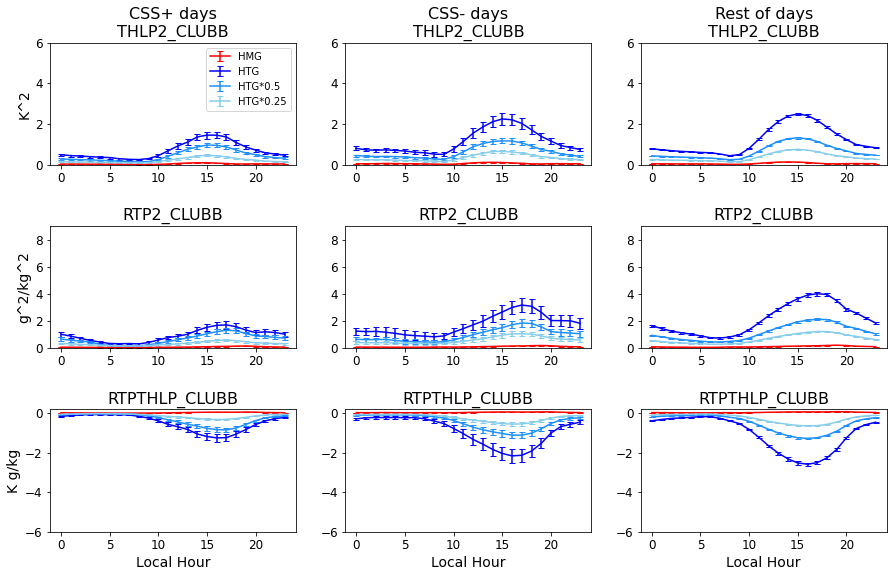

In [89]:
varSel=np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

yMax = np.asarray([6.0, 9.0,  0.2])
yMin = np.asarray([0.0, 0.0, -6.0])

diurnalCycle_sfcVars(varSel, 'artificial',
                    yMin, yMax)

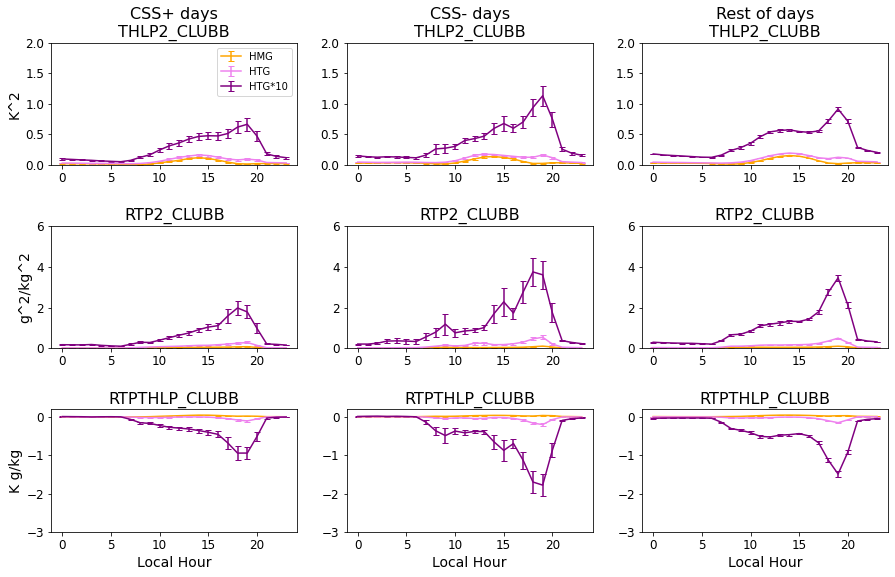

In [90]:
varSel=np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

yMax = np.asarray([2.0, 6.0,  0.2])
yMin = np.asarray([0.0, 0.0, -3.0])

diurnalCycle_sfcVars(varSel, 'real',
                    yMin, yMax)

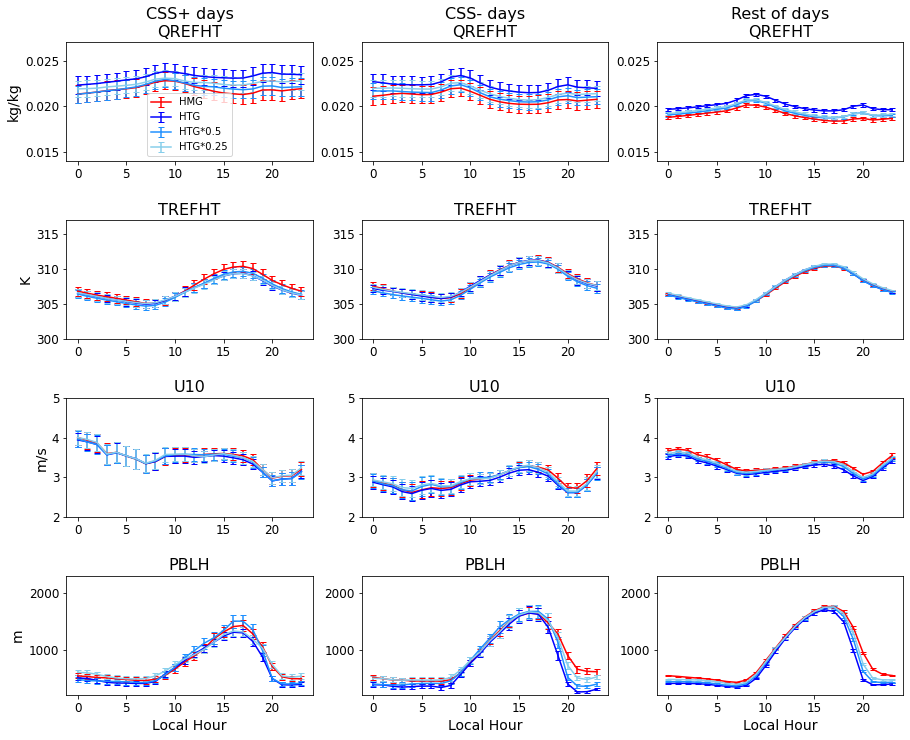

In [91]:
varSel = np.asarray(['QREFHT','TREFHT','U10','PBLH'])

yMax = np.asarray([0.027, 317, 5, 2300])
yMin = np.asarray([0.014, 300, 2,  200])

diurnalCycle_sfcVars(varSel, 'artificial',
                     yMin, yMax)


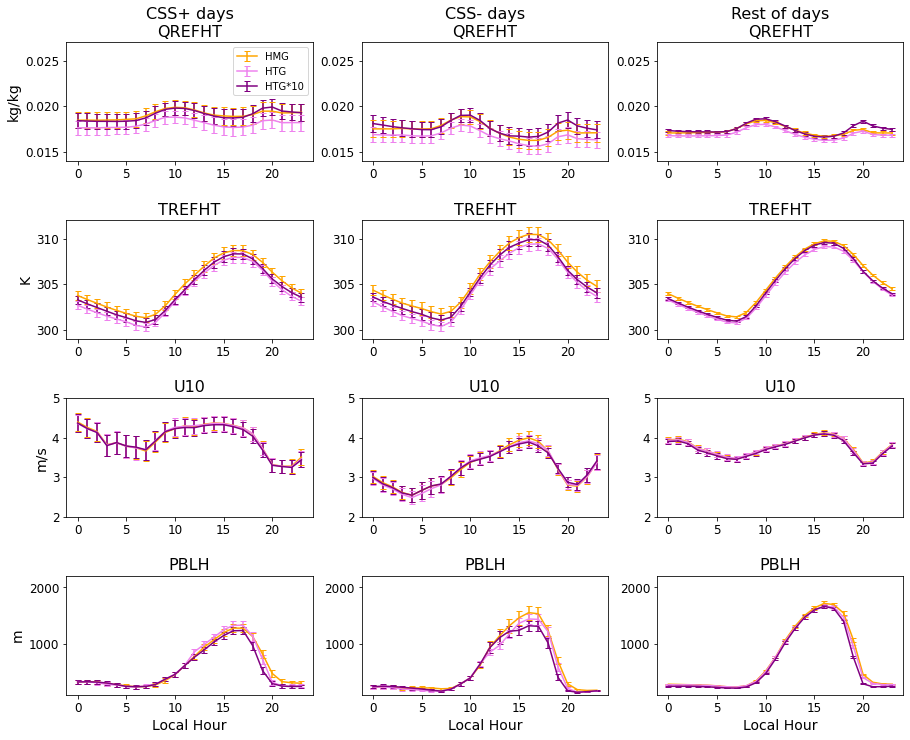

In [92]:
varSel = np.asarray(['QREFHT','TREFHT','U10','PBLH'])

yMax = np.asarray([0.027, 312, 5, 2200])
yMin = np.asarray([0.014, 299, 2,  100])

diurnalCycle_sfcVars(varSel, 'real',
                     yMin, yMax)


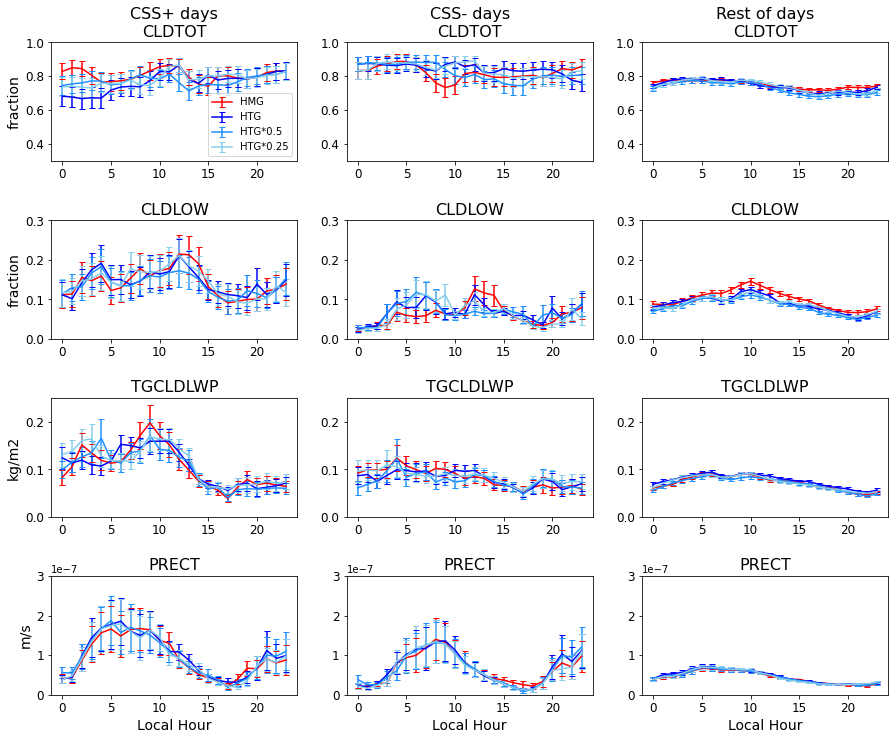

In [93]:
varSel = np.asarray(['CLDTOT','CLDLOW','TGCLDLWP','PRECT'])

yMax = np.asarray([1.0, 0.3, 0.25, 0.3e-6])
yMin = np.asarray([0.3, 0.0, 0.0,  0.0])

diurnalCycle_sfcVars(varSel, 'artificial',
                     yMin, yMax)


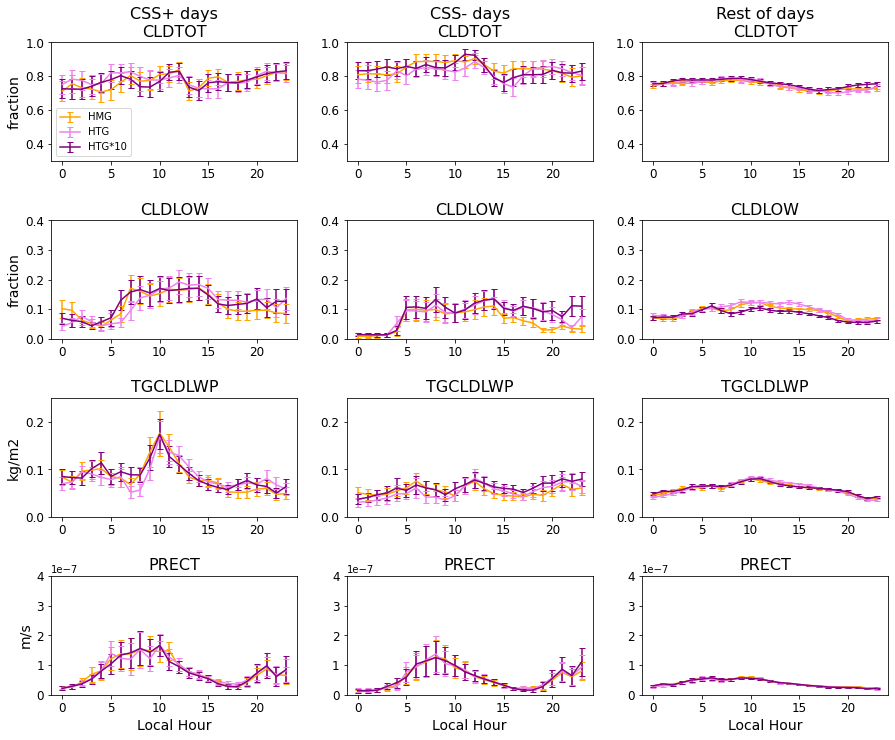

In [94]:
varSel = np.asarray(['CLDTOT','CLDLOW','TGCLDLWP','PRECT'])

yMax = np.asarray([1.0, 0.4, 0.25, 0.4e-6])
yMin = np.asarray([0.3, 0.0, 0.0,  0.0])

diurnalCycle_sfcVars(varSel, 'real',
                     yMin, yMax)


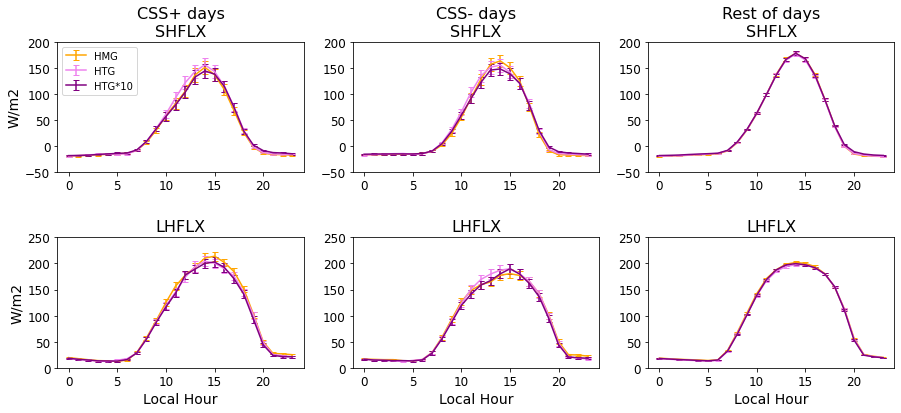

In [27]:
varSel = np.asarray(['SHFLX','LHFLX'])

yMax = np.asarray([200,250])
yMin = np.asarray([-50,  0])

diurnalCycle_sfcVars(varSel, 'real',
                     yMin, yMax)


In [26]:
## Add in EF  

realSfc_allCases_posCSS['EF']  = ( ('case','time','lat,','lon'),
                   (realSfc_allCases_posCSS['LHFLX']/(realSfc_allCases_posCSS['LHFLX']+realSfc_allCases_posCSS['SHFLX'])) )
                              
                              
realSfc_allCases_negCSS['EF']  = (('case','time','lat,','lon'),
                   (realSfc_allCases_negCSS['LHFLX']/(realSfc_allCases_negCSS['LHFLX']+realSfc_allCases_negCSS['SHFLX'])) )




realSfc_allCases_posCSS['EF'].attrs['units']   = '-'
realSfc_allCases_negCSS['EF'].attrs['units'] = '-'


realSfc_allCases_posCSS['EF'].attrs['long_name']   = 'Evaporative Fraction'
realSfc_allCases_negCSS['EF'].attrs['long_name'] = 'Evaporative Fraction'



In [39]:
hourlyMean_posCSS_realSfcEF    = realSfc_allCases_posCSS['EF'].groupby("time.hour").mean(dim="time")
hourlyMean_negCSS_realSfcEF    = realSfc_allCases_negCSS['EF'].groupby("time.hour").mean(dim="time")

hourlyStd_posCSS_realSfcEF    = realSfc_allCases_posCSS['EF'].groupby("time.hour").std(dim="time")
hourlyStd_negCSS_realSfcEF    = realSfc_allCases_negCSS['EF'].groupby("time.hour").std(dim="time")


Text(0.5, 1.0, 'CSS- Days\nEF')

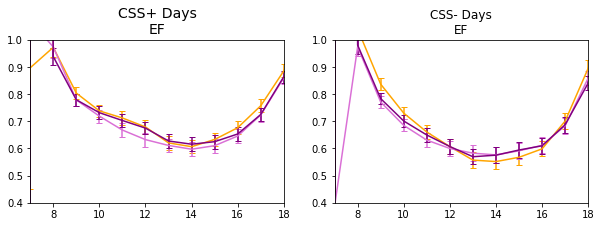

In [45]:
## Set up plots 
fig,axs = plt.subplots(1,2, figsize=(10,1*3))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

    
axs[0].errorbar(np.arange(24), np.squeeze(hourlyMean_posCSS_realSfcEF[0,:]),
                yerr =2*np.squeeze(hourlyStd_posCSS_realSfcEF[0,:])/np.sqrt(hourlyMean_posCSS_realSfc['SampleCount'].values), 
                capsize=3, color='orange')
axs[0].errorbar(np.arange(24), np.squeeze(hourlyMean_posCSS_realSfcEF[1,:]),
                yerr =2*np.squeeze(hourlyStd_posCSS_realSfcEF[1,:])/np.sqrt(hourlyMean_posCSS_realSfc['SampleCount'].values), 
                capsize=3, color='orchid')
axs[0].errorbar(np.arange(24), np.squeeze(hourlyMean_posCSS_realSfcEF[2,:]),
                yerr =2*np.squeeze(hourlyStd_posCSS_realSfcEF[2,:])/np.sqrt(hourlyMean_posCSS_realSfc['SampleCount'].values), 
                capsize=3, color='purple')

axs[1].errorbar(np.arange(24), np.squeeze(hourlyMean_negCSS_realSfcEF[0,:]),
                yerr =2*np.squeeze(hourlyStd_negCSS_realSfcEF[0,:])/np.sqrt(hourlyMean_negCSS_realSfc['SampleCount'].values), 
                capsize=3, color='orange')
axs[1].errorbar(np.arange(24), np.squeeze(hourlyMean_negCSS_realSfcEF[1,:]),
                yerr =2*np.squeeze(hourlyStd_negCSS_realSfcEF[1,:])/np.sqrt(hourlyMean_negCSS_realSfc['SampleCount'].values),
                capsize=3, color='orchid')
axs[1].errorbar(np.arange(24), np.squeeze(hourlyMean_negCSS_realSfcEF[2,:]),
                yerr =2*np.squeeze(hourlyStd_negCSS_realSfcEF[2,:])/np.sqrt(hourlyMean_negCSS_realSfc['SampleCount'].values),
                capsize=3, color='purple')

axs[0].set_xlim([7,18])
axs[1].set_xlim([7,18])

axs[0].set_ylim([0.4,1])
axs[1].set_ylim([0.4,1])

axs[0].set_title('CSS+ Days\nEF',fontsize=14)
axs[1].set_title('CSS- Days\nEF')


In [41]:
np.shape(hourlyStd_negCSS_realSfcEF)

(3, 24, 1, 1)